# Overview
Supply region resolution - 
- 1 - whole of RSA
- 10 - Eskom defined transmission regions
- 34 - Eskom defined local supply areas

Sub-region options:
- All area
- Renewable Energy Development Zones
- Power Corridors
- Active EIA applications
- REDZ + EIA applications 

Intra-region aggregation options:
- Average all available cells
- Weight cells by availability matrix
- Quantile

# Setting up ERA5 cutout using atlite

In [33]:
import atlite
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rioxarray
from dask.distributed import Client, LocalCluster
import os

from _helpers import(
    load_gis_data,
    load_turbine_power_curves,
    generate_wind_timeseries,
    aggregate_intra_region,
    calculate_voronoi_for_supply_region,
    select_intra_region_voronoi,
    calc_wasa_timeseries,
)

import warnings
warnings.filterwarnings('ignore')

In [34]:
agg_params = {
    "availability_threshold":0,
    "scale_by_availability": False,      
    "aggregation_method":"quantile", # quantile
    "quantile": 0.9,
}

run_generation = True
run_validation = True
apply_gwa_correction = True

In [35]:
#Before running this script you must build an era5 cutout for South Africa using the atlite module
cutout = atlite.Cutout(
    path="../../cutouts/RSA-2010_22-era5.nc",
    chunks={'time': 100}
)
cutout.data = cutout.data.sel(time=~((cutout.data.time.dt.month == 2) & (cutout.data.time.dt.day == 29)))

if apply_gwa_correction:
    gwa_data = rioxarray.open_rasterio("../../data/bundle/ZAF_wind-speed_100m.tif")
    ds=gwa_data.sel(band=1, x=slice(*cutout.extent[[0,1]]), y=slice(*cutout.extent[[3,2]]))
    ds=ds.where(ds!=-999)
    ds=atlite.gis.regrid(ds,cutout.data.x, cutout.data.y,resampling=rasterio.warp.Resampling.average)

    bias_correction = ds/cutout.data.wnd100m.mean("time") 
    bias_correction=bias_correction.fillna(1)
    cutout.data.wnd100m.values=(bias_correction*cutout.data.wnd100m).transpose('time', 'y', 'x').values

# Generate wind power data

In [36]:
turbine_class, turbine_power_curves = load_turbine_power_curves('../../data/turbine_power_curves.csv')

In [37]:
for hub_height in [80, 120, 140]:
    cutout.data[f"wnd{hub_height}m"] = atlite.wind.extrapolate_wind_speed(cutout.data, hub_height, from_height=100)

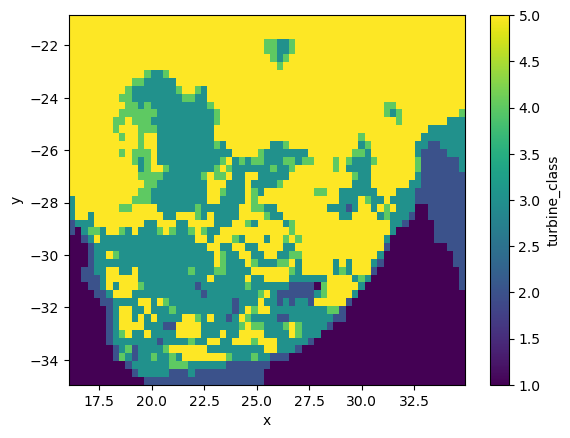

In [38]:
cutout.data["turbine_class"] = xr.full_like(cutout.data['wnd80m'].mean("time"), 5, dtype='int')
cutout.data["turbine_class"] = xr.where((cutout.data['wnd120m'].mean("time") < 7.5) & (cutout.data['wnd120m'].mean("time") > 6), 4, cutout.data["turbine_class"])
cutout.data["turbine_class"] = xr.where((cutout.data['wnd100m'].mean("time") < 7.5) & (cutout.data['wnd100m'].mean("time") > 6), 3, cutout.data["turbine_class"])
cutout.data["turbine_class"] = xr.where((cutout.data['wnd80m'].mean("time") < 8.5) & (cutout.data['wnd100m'].mean("time") > 7.5), 2, cutout.data["turbine_class"])
cutout.data["turbine_class"] = xr.where(cutout.data['wnd80m'].mean("time") > 8.5, 1, cutout.data["turbine_class"])
cutout.data["turbine_class"].plot()


In [39]:
era5_pu = xr.DataArray(
    np.zeros((len(cutout.data.time), len(cutout.grid.y.unique()), len(cutout.grid.x.unique()))),
    coords = {
        "time": cutout.coords["time"], 
        "lat": cutout.grid.y.unique(),
        "lon": cutout.grid.x.unique()},
    dims = ["time", "lat","lon"],
)

In [40]:
for _class in range(1,6):
    print(f"Generating timeseries for turbine class {_class}")
    timeseries = generate_wind_timeseries(cutout, turbine_class[_class])
    mask = (cutout.data["turbine_class"] == _class).compute()
    mask = mask.swap_dims({"y": "lat", "x": "lon"})
    era5_pu += timeseries.where(mask, 0)

Generating timeseries for turbine class 1
[########################################] | 100% Completed | 26.61 s
Generating timeseries for turbine class 2
[########################################] | 100% Completed | 25.92 s
Generating timeseries for turbine class 3
[########################################] | 100% Completed | 22.15 s
Generating timeseries for turbine class 4
[########################################] | 100% Completed | 26.78 s
Generating timeseries for turbine class 5
[########################################] | 100% Completed | 25.67 s


# Load GIS data

In [41]:
data_bundle_path = "../../data/bundle"
gis_data = load_gis_data(data_bundle_path)

wasa_gps = pd.read_csv('../../data/weather/wasa_gps.csv')
wasa_gps = gpd.GeoDataFrame(wasa_gps, geometry=gpd.points_from_xy(wasa_gps.Longitude, wasa_gps.Latitude), crs=4326)
wasa_gps = gpd.sjoin(wasa_gps, gis_data["supply_regions"][1], how="inner", op='intersects')
wasa_gps = wasa_gps.drop(columns=['index_right'])

for i in wasa_gps.index:
    wasa_gps.loc[i, "cleaned_file_name"] = wasa_gps.loc[i, "file_name"].replace(".csv","")

Loading Eskom Supply Regions from ../../data/bundle/rsa_supply_regions.gpkg
Loading EIA applications from ../../data/bundle/REEA_OR_2023_Q3.shp
Loading REDZs from ../../data/bundle/REDZs.shp
Loading Power Corridors from ../../data/bundle/Power_corridors.shp
Loading SACAD from ../../data/bundle/SACAD_OR_2023_Q3.shp
Loading SAPAD from ../../data/bundle/SAPAD_OR_2023_Q3.shp
Loading SKA exclusion from ../../data/bundle/SKA/SKA_exclusion.shp


In [43]:
if run_generation:
    for region_num in gis_data["supply_regions"].keys(): 
        bus_list = gis_data["supply_regions"][region_num].name.to_list()
        availability_matrix = xr.open_dataarray(f"availability/availability_matrix_{region_num}.nc")
        
        timeseries = xr.DataArray(
            coords = {
                "time": era5_pu.time, 
                "bus": bus_list, 
                "intra_region": ["all", "redz", "corridors", "redz_corridors_eia"]},
            dims = ["time", "bus", "intra_region"],
        )
        for intra_region in ["all", "redz", "corridors", "redz_corridors_eia"]:
            print(f"Supply regions: {region_num}, Intra region area: {intra_region}")
            for region in availability_matrix.coords["bus"].values:
                region_availability = availability_matrix.sel(area=intra_region, bus=region).rename({"y":"lat","x":"lon"})
                timeseries.loc[dict(bus=region, intra_region = intra_region)] = aggregate_intra_region(era5_pu, region_availability, **agg_params)
        
        timeseries.to_netcdf(f"timeseries_data/extendable_wind_era5_{region_num}.nc")

Supply regions: 1, Intra region area: all
Supply regions: 1, Intra region area: redz
Supply regions: 1, Intra region area: corridors
Supply regions: 1, Intra region area: redz_corridors_eia
Supply regions: 10, Intra region area: all
Supply regions: 10, Intra region area: redz
Supply regions: 10, Intra region area: corridors
Supply regions: 10, Intra region area: redz_corridors_eia
Supply regions: 27, Intra region area: all
Supply regions: 27, Intra region area: redz
Supply regions: 27, Intra region area: corridors
Supply regions: 27, Intra region area: redz_corridors_eia
Supply regions: 34, Intra region area: all
Supply regions: 34, Intra region area: redz
Supply regions: 34, Intra region area: corridors
Supply regions: 34, Intra region area: redz_corridors_eia
Supply regions: 159, Intra region area: all
Supply regions: 159, Intra region area: redz
Supply regions: 159, Intra region area: corridors
Supply regions: 159, Intra region area: redz_corridors_eia


# WASA processing

In [48]:
if run_generation:
    wasa_pu = xr.open_dataarray("timeseries_data/wasa_profiles.nc").to_pandas()

    for regions in gis_data["supply_regions"].keys():
        supply_regions = gis_data["supply_regions"][regions]
        gdf_points = gpd.GeoDataFrame(wasa_gps, geometry=gpd.points_from_xy(wasa_gps['Longitude'], wasa_gps['Latitude']), crs='EPSG:4326')
        gdf_points = gdf_points[gdf_points.geometry.within(supply_regions.unary_union)]
        gdf_points = gdf_points.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')

        voronoi_gdfs = {
            region_name: calculate_voronoi_for_supply_region(
                supply_regions, gdf_points, region_name
            )
            for region_name in supply_regions['name'].unique()
        }
        all_voronoi_gdf = pd.concat(
            [gdf.assign(region_name=region_name) for region_name, gdf in voronoi_gdfs.items()],
            ignore_index=False)
        all_voronoi_gdf.crs = 'EPSG:4326'

        timeseries = xr.DataArray(
            coords = {
                "time": wasa_pu.index, 
                "bus": supply_regions.name, 
                "intra_region": ["all", "redz", "corridors", "redz_corridors_eia"]},
            dims = ["time", "bus", "intra_region"],
        )

        for intra_region in ["all", "redz", "corridors", "redz_corridors_eia"]:

            voronoi_active = all_voronoi_gdf if intra_region == "all" else select_intra_region_voronoi(all_voronoi_gdf, gis_data[intra_region])
            for r in supply_regions.name:
                timeseries.loc[:, r, intra_region] = calc_wasa_timeseries(voronoi_active, r, wasa_pu, method = "area_weighted").values
        timeseries.to_netcdf(f"timeseries_data/extendable_wind_wasa_{regions}.nc")

Number of points in RSA: 1714
Number of points in Eastern Cape: 217
Number of points in Free State: 43
Number of points in Gauteng: 78
Number of points in Hydra Central: 137
Number of points in KwaZulu Natal: 124
Number of points in Limpopo: 206
Number of points in Mpumalanga: 228
Number of points in North West: 40
Number of points in Northern Cape: 323
Number of points in Western Cape: 318
Number of points in Namaqualand: 115
Number of points in West Coast: 90
Number of points in Peninsula: 81
Number of points in Southern Cape: 229
Number of points in Port Elizabeth: 143
Number of points in Karoo: 162
Number of points in Kimberley: 83
Number of points in Carletonville: 28
Number of points in Welkom: 21
Number of points in Bloemfontein: 64
Number of points in East London: 93
Number of points in Pinetown: 34
Number of points in Ladysmith: 19
Number of points in Vaal Triangle: 16
Number of points in West Rand: 25
Number of points in Rustenburg: 10
Number of points in Waterberg: 17
Number

In [ ]:
for module in ["csir"]:

    for r in [1, 27]:
        availability_matrix = xr.open_dataarray(f"availability/availability_matrix_{r}.nc")
        csir_fise = pd.read_excel("csir_fise_SWA_data.xlsx", sheet_name = f"{r}-wind", index_col=0, parse_dates=True)
        csir_fise = csir_fise.iloc[1:]
        csir_fise.index = pd.DatetimeIndex(csir_fise.index)
        csir_fise = csir_fise[~((csir_fise.index.month == 2) & (csir_fise.index.day == 29))]

        csir_fise = pd.concat(
            [csir_fise]
            * int(np.ceil(len(cutout.data.coords["time"].values) / len(csir_fise))),
            ignore_index=True,
        )  
        csir_fise = csir_fise.iloc[:len(cutout.data.coords["time"].values)]

        timeseries = xr.DataArray(
            coords = {
                "time": cutout.data.coords["time"].values, 
                "bus": availability_matrix.coords["bus"], 
                "intra_region": ["all", "redz", "corridors", "redz_corridors_eia"]},
            dims = ["time", "bus", "intra_region"],
        )

        for intra_region in timeseries.coords["intra_region"].values:
            for bus in availability_matrix.coords["bus"].values:
                print(f"Calculating average based on intra region area: {intra_region} for bus: {bus}")
                timeseries.loc[dict(bus=bus, intra_region=intra_region)] = csir_fise[bus].values

        timeseries.to_netcdf(f"timeseries_data/extendable_wind_{module}_{r}.nc")

Calculating average based on intra region area: all for bus: RSA
Calculating average based on intra region area: redz for bus: RSA
Calculating average based on intra region area: corridors for bus: RSA
Calculating average based on intra region area: redz_corridors_eia for bus: RSA
Calculating average based on intra region area: all for bus: Namaqualand
Calculating average based on intra region area: all for bus: West Coast
Calculating average based on intra region area: all for bus: Peninsula
Calculating average based on intra region area: all for bus: Southern Cape
Calculating average based on intra region area: all for bus: Port Elizabeth
Calculating average based on intra region area: all for bus: Karoo
Calculating average based on intra region area: all for bus: Kimberley
Calculating average based on intra region area: all for bus: Carletonville
Calculating average based on intra region area: all for bus: Welkom
Calculating average based on intra region area: all for bus: Bloemfont